In [3]:
import numpy as np
import gzip
import matplotlib.cm as cm
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Load images
mat = np.load('data/faces.npz')['arr_0'].astype(np.float64)

# Drastically reduce the resolution
def half_resolution(X, rep=1):
    for _ in range(rep):
        r, c = 2 * (X.shape[0] // 2), 2 * (X.shape[1] // 2)
        X = 0.25 * (X[:r:2, :c:2] + X[1:r:2, 1:c:2] + X[1:r:2, :c:2] + X[:r:2, 1:c:2])
    return X

images_small = []
for i in range(mat.shape[0]):
    images_small.append(half_resolution(mat[i], 2))
mat = np.array(images_small)
X = (2.0 * mat / 255.0 - 1.0)

N = mat.shape[0]
h = mat.shape[1]
w = mat.shape[2]

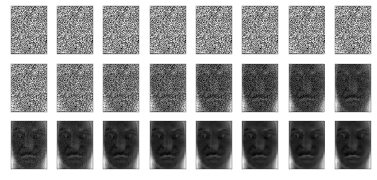

In [5]:
# Generate a random encoder
e = np.random.normal(0, 1, w * h)
e = e / np.linalg.norm(e)

# Learning rate
η = 0.2e-4

# Number of learning steps
N = 10000

# Plot 10 images
fig, axs = plt.subplots(3, 8, figsize=(6.5, 3))
axs = axs.flatten()
smpl_idcs = np.linspace(0, N - 1, axs.size).astype(int)
smpl_idx = 0
cmap = cm.get_cmap('gray')

θ = 0
for i in range(N):
    # Randomly select an image
    idx = np.random.randint(X.shape[0])
    x = X[idx].reshape(-1) - np.mean(X.reshape(-1, w * h), axis=0)

    if i in smpl_idcs:
        axs[smpl_idx].imshow(e.reshape(h, w), cmap=cmap)
        axs[smpl_idx].set_xticks([])
        axs[smpl_idx].set_yticks([])
        smpl_idx += 1

    # Compute the activity
    a = e @ x

    # Update the weights
    e += η * x * a
    e = e / np.linalg.norm(e)

fig.savefig('../hebbian_learning_example.pdf', transparent=True, bbox_inches='tight')

In [6]:
import nengo

In [77]:
def build_unsupervised_learning_model(X, dp=4):
    N, d = X.shape
    rnds = np.random.randint(0, N, 10000)
    with nengo.Network() as model:
        # Inputs
        nd_input = nengo.Node(lambda t: X[rnds[int(t / 0.1)]])

        # Ensemble of d spiking neurons with dimensionality d --
        # each neuron represents a single pixel.
        ens_retina = nengo.Ensemble(
            n_neurons=d,
            dimensions=d,
            intercepts=-np.ones(d),
            encoders=np.eye(d),
            max_rates=200 * np.ones(d),
        )
        nengo.Connection(nd_input, ens_retina.neurons)

        # Project onto a single neuron
        ens_target = nengo.Ensemble(
            n_neurons=dp, dimensions=dp,
            encoders=np.eye(dp),
            intercepts=-1*np.ones(dp),
            max_rates=200 * np.ones(dp)
        )
        con = nengo.Connection(ens_retina.neurons, ens_target.neurons,
                         transform=np.random.normal(0, 1, (dp, d)),
                         learning_rule_type=nengo.BCM(learning_rate=1e-7))

        p_weights = nengo.Probe(con, 'weights', sample_every=0.1)

    return model, p_weights

In [79]:
Xq = X[:, 7:-8, :] # Make X a 45 x 45 image

net, p = build_unsupervised_learning_model(Xq.reshape(84, 45*45))
with nengo.Simulator(net) as sim:
    sim.run(100.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

KeyboardInterrupt: 

In [ ]:
# Plot 10 images
weights = sim.data[p]
N = weights.shape[0]
fig, axs = plt.subplots(3, 8, figsize=(6.5, 3))
axs = axs.flatten()
smpl_idcs = np.linspace(0, N - 1, axs.size).astype(int)
smpl_idx = 0
cmap = cm.get_cmap('gray')

θ = 0
for i in range(N):
    if i in smpl_idcs:
        axs[smpl_idx].imshow(weights[smpl_idcs[smpl_idx]][0].reshape(w, w), cmap=cmap)
        axs[smpl_idx].set_xticks([])
        axs[smpl_idx].set_yticks([])
        smpl_idx += 1

fig.savefig('../hebbian_learning_example_nengo.pdf', transparent=True, bbox_inches='tight')